<div style="background-color: #e0f7fa; padding: 15px; border-radius: 8px;">
<h1 style="color: #00796b; font-family: Arial, sans-serif; font-size: 36px; text-align: left;">SMS Spam Classification using Natural Language Processing (NLP)</h1>
</div>

## Table of Contents

1. [Introduction](#1-Introduction)
2. [Import Necessary Packages](#2-Import-Necessary-Packages)
3. [Data Import](#3-Data-Import)
4. [Data Preprocessing](#4-Data-Preprocessing)
   1. [Punctuation Removal and Lowercasing](#41-Punctuation-Removal-and-Lowercasing)
   2. [Tokenization](#42-Tokenization)
   3. [Stop Word Removal](#43-Stop-Word-Removal)
   4. [Lemmatization](#44-Lemmatization)
5. [Text Vectorization](#5-Text-Vectorization)
6. [Model Building](#6-Model-Building)
7. [Model Evaluation](#7-Model-Evaluation)
8. [Conclusion](#8-Conclusion)

---

## 1. Introduction
This notebook demonstrates how to classify SMS messages as either "spam" or "ham" (non-spam) using natural language processing (NLP) and machine learning. We use the SMS Spam Collection dataset from the UCI Machine Learning Repository for this task.

**Dataset Attribution:**  
The SMS Spam Collection dataset is licensed under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license. This dataset was contributed by Almeida, T.A., Hidalgo, J.M.G., & Yamakami, A.. Any changes to the dataset are for preprocessing and analysis purposes in this notebook.

For more information about the dataset, visit the [UCI SMS Spam Collection Dataset Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#).

---

## 2. Import Necessary Packages

The following libraries are used in this notebook:

- **numpy**: For numerical computations.
- **pandas**: For data manipulation and analysis using DataFrames.
- **matplotlib** and **seaborn**: For data visualization.
- **nltk**: Natural Language Toolkit for text processing tasks. This includes:
  - **stopwords**: A module to filter out common English words that do not add much meaning to the text.
  - **wordnet**: A lexical database used for lemmatization in this notebook. It also provides rich semantic information, such as synonyms, antonyms, definitions, and relationships between words.
- **re** and **string**: For regular expressions and string manipulations during text preprocessing.
- **sklearn**: A machine learning library for building and evaluating the classification model (includes modules for model selection, vectorization, and metrics).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rkura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rkura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

## 3. Data Import
This notebook uses the UCI SMS Spam Collection dataset. It consists of a collection of SMS messages labeled as "ham" (legitimate) or "spam".

The dataset is in a tab-separated format, with the first column representing the label and the second column containing the text message.

In [3]:
# Load the dataset into a pandas DataFrame
sms_df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'SMS_text'], encoding='utf-8')

# Display the first few rows of the DataFrame
display(sms_df.head())

# Display the number of rows and unique values in the 'label' and 'SMS_text' column
display(sms_df.describe())

,label,SMS_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


,label,SMS_text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


---

## 4. Data Preprocessing
Text preprocessing involves several steps:
1. Removing punctuation and converting to lowercase.
2. Tokenizing the text into words.
3. Removing stop words (common words with little semantic meaning).
4. Lemmatizing the text to convert words to their base form.

### 4.1. Punctuation Removal and Lowercasing
Remove punctuation from the text and convert all characters to lowercase for standardization.

In [4]:
# Remove punctuation and convert to lowercase
sms_df['SMS_text_clean'] = sms_df['SMS_text'].apply(lambda x: ''.join([char for char in x.lower() if char not in string.punctuation]))

# Display a sample of the cleaned text
sms_df['SMS_text_clean'].head()

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: SMS_text_clean, dtype: object

### 4.2. Tokenization
Split the cleaned text into individual words (tokens).

In [5]:
# Tokenize the text using regular expressions to split on non-word characters
sms_df['tokens'] = sms_df['SMS_text_clean'].apply(lambda x: re.findall(r'\b\w+\b', x))

# Display a sample of the tokenized text
sms_df['tokens'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: tokens, dtype: object

### 4.3. Stop Word Removal
Remove common English stop words that do not contribute significantly to the meaning of the text.

In [6]:
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Remove stop words
sms_df['tokens_nostop'] = sms_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Display a sample of the text after stop word removal
sms_df['tokens_nostop'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: tokens_nostop, dtype: object

### 4.4. Lemmatization
Reduce each word to its base form using lemmatization.

In [7]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the tokens
sms_df['tokens_lemmatized'] = sms_df['tokens_nostop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Display a sample of the lemmatized text
sms_df['tokens_lemmatized'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, go, usf, life, around, though]
Name: tokens_lemmatized, dtype: object

---

## 5. Text Vectorization
Convert the cleaned and lemmatized text into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). This step transforms text data into a format suitable for machine learning algorithms.

In [8]:
# Initialize the TF-IDF vectorizer
tfidf_vect = TfidfVectorizer()

# Convert the text data into TF-IDF feature vectors
X_tfidf = tfidf_vect.fit_transform(sms_df['tokens_lemmatized'].apply(lambda x: ' '.join(x))).toarray()

# Display the vocabulary size and the shape of the feature matrix
print(f"Vocabulary Size: {len(tfidf_vect.vocabulary_)}")
print(f"TF-IDF Feature Matrix Shape: {X_tfidf.shape}\n")

# Display the first 5 items in the vocabulary
print('First 5 items in the vocabulary:')
for word, index in list(tfidf_vect.vocabulary_.items())[:5]:
    print(f"Word: '{word}', Index: {index}")

Vocabulary Size: 8885
TF-IDF Feature Matrix Shape: (5572, 8885)

First 5 items in the vocabulary:
Word: 'go', Index: 3610
Word: 'jurong', Index: 4458
Word: 'point', Index: 6079
Word: 'crazy', Index: 2401
Word: 'available', Index: 1391


In [9]:
# Get the feature names (words) in the order of their indices in the matrix
feature_names = np.array(tfidf_vect.get_feature_names_out())

# Select a sample message (e.g., the first message in the dataset) and its TF-IDF vector
sample_index = 0
sample_vector = X_tfidf[sample_index]

# Get the indices of non-zero elements in the sample vector (i.e., words with non-zero TF-IDF scores)
non_zero_indices = sample_vector.nonzero()[0]

# Display the words and their corresponding TF-IDF values for the sample message
print(f"\nWords in sample message {sample_index} with their TF-IDF scores:")
for idx in non_zero_indices:
    print(f"Word: '{feature_names[idx]}', Index: {idx}, TF-IDF Score: {sample_vector[idx]:.3f}")


Words in sample message 0 with their TF-IDF scores:
Word: 'amore', Index: 1167, TF-IDF Score: 0.349
Word: 'available', Index: 1391, TF-IDF Score: 0.265
Word: 'buffet', Index: 1829, TF-IDF Score: 0.333
Word: 'bugis', Index: 1831, TF-IDF Score: 0.295
Word: 'cine', Index: 2139, TF-IDF Score: 0.295
Word: 'crazy', Index: 2401, TF-IDF Score: 0.270
Word: 'go', Index: 3610, TF-IDF Score: 0.155
Word: 'got', Index: 3663, TF-IDF Score: 0.164
Word: 'great', Index: 3701, TF-IDF Score: 0.194
Word: 'jurong', Index: 4458, TF-IDF Score: 0.349
Word: 'la', Index: 4610, TF-IDF Score: 0.295
Word: 'point', Index: 6079, TF-IDF Score: 0.238
Word: 'wat', Index: 8420, TF-IDF Score: 0.199
Word: 'world', Index: 8638, TF-IDF Score: 0.237


---

## 6. Model Building
We use a Random Forest classifier with GridSearchCV for hyperparameter tuning to build the prediction model.

In [10]:
# Set up the RandomForest model and hyperparameter tuning using GridSearchCV
param_grid = {
   'n_estimators': [10, 20],
   'max_depth': [50, 100, 200]
}

# Initialize the RandomForest classifier
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3)
grid_search.fit(X_tfidf, sms_df['label'])


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....max_depth=50, n_estimators=10;, score=0.980 total time=   1.4s
[CV 2/5] END .....max_depth=50, n_estimators=10;, score=0.969 total time=   1.2s
[CV 3/5] END .....max_depth=50, n_estimators=10;, score=0.969 total time=   1.3s
[CV 4/5] END .....max_depth=50, n_estimators=10;, score=0.961 total time=   1.1s
[CV 5/5] END .....max_depth=50, n_estimators=10;, score=0.961 total time=   1.3s
[CV 1/5] END .....max_depth=50, n_estimators=20;, score=0.980 total time=   2.2s
[CV 2/5] END .....max_depth=50, n_estimators=20;, score=0.969 total time=   2.2s
[CV 3/5] END .....max_depth=50, n_estimators=20;, score=0.966 total time=   2.2s
[CV 4/5] END .....max_depth=50, n_estimators=20;, score=0.960 total time=   2.1s
[CV 5/5] END .....max_depth=50, n_estimators=20;, score=0.957 total time=   2.1s
[CV 1/5] END ....max_depth=100, n_estimators=10;, score=0.979 total time=   1.8s
[CV 2/5] END ....max_depth=100, n_estimators=10;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [50, 100, 200], 'n_estimators': [10, 20]},
             scoring='accuracy', verbose=3)

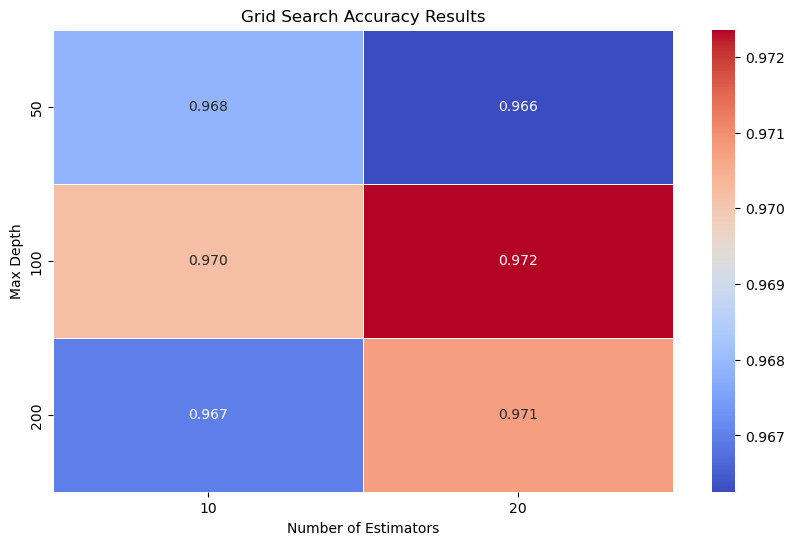

In [11]:
# Extract and visualize GridSearchCV results using a heatmap
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".3f", linewidths=.5)
plt.title('Grid Search Accuracy Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

---

## 7. Model Evaluation
Evaluate the model's performance using a confusion matrix.

Best parameters found: {'max_depth': 100, 'n_estimators': 20}
Best cross-validation score: 0.972


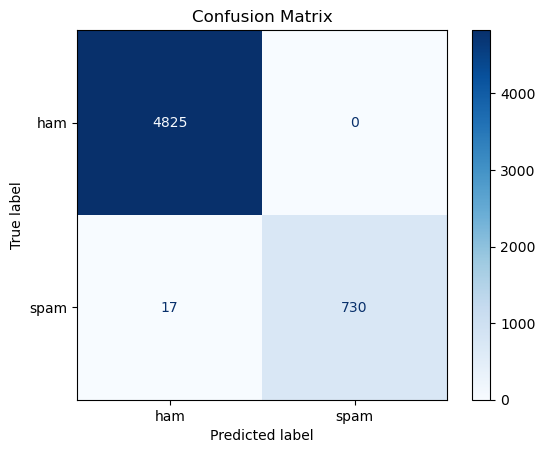

In [12]:
# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Predict on the dataset using the best model from grid search
y_pred = grid_search.best_estimator_.predict(X_tfidf)

# Plot the confusion matrix
cm = confusion_matrix(sms_df['label'], y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

---

## 8. Conclusion
The model successfully classifies SMS messages with high accuracy, as evidenced by the confusion matrix, which demonstrates its effectiveness in distinguishing between "spam" and "ham" messages.

However, the current code does not address certain challenges in the dataset, such as the presence of special characters (e.g., "£", "http://"), numerical sequences (e.g., phone numbers, prices), and various punctuation marks. Additionally, handling slang, abbreviations, and misspellings is crucial for accurate classification, especially in informal text like SMS messages.

Future improvements could involve refining text preprocessing to include handling of these symbols, URLs, numbers, and slang. Additionally, using advanced NLP techniques such as word embeddings, transformers (e.g., BERT), or other machine learning algorithms could further enhance the model's ability to capture the contextual meaning of these elements for better spam detection.